# The `to_dict` method for `PhaseDiagram` and `StateVec` objects

The `to_dict` method returns a Python dictionary containing a selection of properties.
It can be used to conveniently create a `pandas.DataFrame` (to then store or plot data).

In [47]:
from feos.si import *
from feos.pcsaft import *
from feos.eos import *
from feos.dippr import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_palette('Dark2')
sns.set_style('ticks')
colors = sns.palettes.color_palette('Dark2', 8)

In [48]:
pc_saft_parameters = PcSaftParameters.from_json(substances = ['water'], pure_path = "../parameters/pcsaft/esper2023.json")
dippr_parameters = Dippr.from_json(substances = ['water'], pure_path = "../parameters/ideal_gas/poling2000.json")

In [49]:
eos = EquationOfState.pcsaft(pc_saft_parameters).dippr(dippr_parameters)

In [50]:
vle = PhaseDiagram.pure(
    eos=eos,
    min_temperature=100*CELSIUS,
    npoints = 1000,
)

spinodal = PhaseDiagram.spinodal(
    eos=eos,
    moles=SIArray1([MOL]),
    min_temperature=100*CELSIUS,
    npoints = 1000,
)

# isotherm at T = 0.95 * T_c
t = 0.95 * State.critical_point(eos).temperature
isotherm = []
for density in SIArray1.linspace(vle.vapor.density[0], vle.liquid.density[0], 1000):
    state = State(eos, t, density=density)
    isotherm.append({
        "density": density / (MOL / METER**3),
        "pressure": state.pressure() / PASCAL,
        "mass density": state.mass_density() / KILOGRAM * METER**3,
        "specific enthalpy": state.specific_enthalpy() / (KILO * JOULE / KILOGRAM),
    })

In [51]:
df_vle = pd.DataFrame(vle.to_dict())
df_spinodal = pd.DataFrame(spinodal.to_dict())
df_isotherm = pd.DataFrame(isotherm)

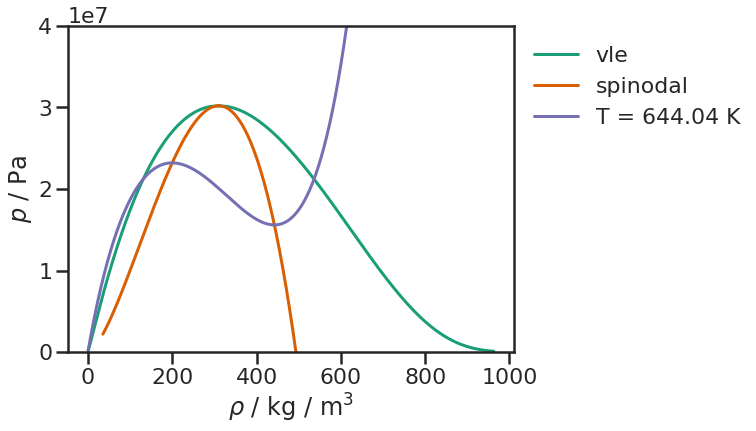

In [52]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df_vle, x="mass density vapor", y="pressure", color=colors[0], label="vle")
sns.lineplot(data=df_vle, x="mass density liquid", y="pressure", color=colors[0])
sns.lineplot(data=df_spinodal, x="mass density vapor", y="pressure vapor", color=colors[1], label="spinodal")
sns.lineplot(data=df_spinodal, x="mass density liquid", y="pressure liquid", color=colors[1])
sns.lineplot(data=df_isotherm, x="mass density", y="pressure", color=colors[2], label=f"T = {t / KELVIN:.2f} K")

plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel(r"$\rho$ / kg / m$^3$")
plt.ylabel(r"$p$ / Pa")
plt.ylim(0, 4e7);

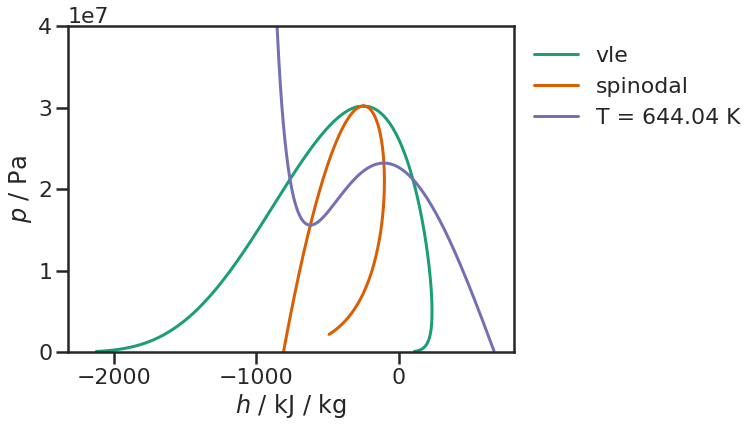

In [53]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df_vle, x="specific enthalpy vapor", y="pressure", color=colors[0], sort=False, label="vle")
sns.lineplot(data=df_vle, x="specific enthalpy liquid", y="pressure", color=colors[0], sort=False)
sns.lineplot(data=df_spinodal, x="specific enthalpy vapor", y="pressure vapor", color=colors[1], sort=False, label="spinodal")
sns.lineplot(data=df_spinodal, x="specific enthalpy liquid", y="pressure liquid", color=colors[1], sort=False)
sns.lineplot(data=df_isotherm, x="specific enthalpy", y="pressure", color=colors[2], sort=False, label=f"T = {t / KELVIN:.2f} K")

plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel(r"$h$ / kJ / kg")
plt.ylabel(r"$p$ / Pa")
plt.ylim(0, 4e7);

## Using `to_dict` for `StateVec`s.

If you are only interested in one phase of the phase diagram, you can use the `StateVec` objects. They store `State`s of each phase separately and provide methods to conveniently calculate a property for all states. Alternatively, you can use `to_dict` to calculate multiple properties at once.

In [57]:
# pressures of vapor spinodal
spinodal.vapor.pressure

[2195134.723820085, 2203719.551660241, 2212325.9066083375, 2220953.812322047, 2229603.29247895, ..., 29873339.108738653, 29955971.09223245, 30039876.920265026, 30125381.83609625, 30213398.571198866] Pa

In [58]:
# selected properties of the VLE-liquid branch
pd.DataFrame(vle.liquid.to_dict()).head()

,density,mass density,temperature,molar enthalpy,specific enthalpy,pressure,specific entropy,molar entropy
0,53476.954297,963.173424,373.150000,-38.296278,-2126.271605,100461.912545,-3.369185,-0.060682
1,53461.088499,962.887665,373.455093,-38.274789,-2125.078481,101563.880436,-3.365992,-0.060625
2,53445.215431,962.601775,373.760186,-38.253296,-2123.885157,102675.897449,-3.362801,-0.060567
3,53429.335057,962.315754,374.065278,-38.231799,-2122.691631,103798.034685,-3.359612,-0.060510
4,53413.447342,962.029600,374.370371,-38.210299,-2121.497903,104930.363580,-3.356426,-0.060453


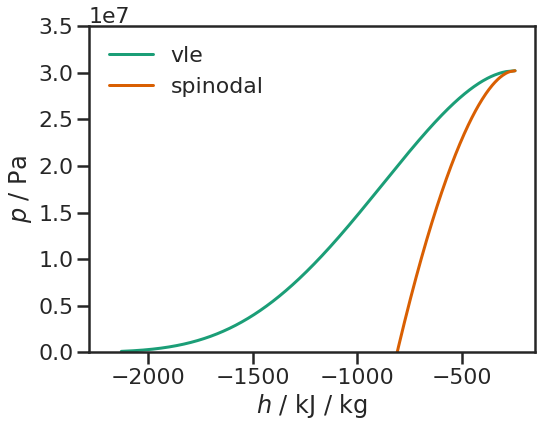

In [59]:
# DataFrames work nicely with seaborn:

plt.figure(figsize=(8,6))
sns.lineplot(
    data=pd.DataFrame(vle.liquid.to_dict()),
    x="specific enthalpy", 
    y="pressure", 
    color=colors[0], 
    sort=False, 
    label="vle"
)
sns.lineplot(
    data=pd.DataFrame(spinodal.liquid.to_dict()),
    x="specific enthalpy", 
    y="pressure", 
    color=colors[1], 
    sort=False, 
    label="spinodal"
)
plt.legend(frameon=False)
plt.xlabel(r"$h$ / kJ / kg")
plt.ylabel(r"$p$ / Pa")
plt.ylim(0, 3.5e7);